In [1]:
import pandas as pd
import numpy as np
import os
import time
import copy
import pathlib, tempfile

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from joblib import Parallel, delayed
from scipy import stats

from survivors import metrics as metr
from survivors import constants as cnt
from survivors import criteria as crit
from numba import njit, jit, int32, float64
from lifelines import KaplanMeierFitter, NelsonAalenFitter

from survivors.ensemble import BootstrapCRAID
import survivors.datasets as ds

import cProfile
import pstats

%load_ext line_profiler
%load_ext scalene

Scalene extension successfully loaded. Note: Scalene currently only
supports CPU+GPU profiling inside Jupyter notebooks. For full Scalene
profiling, use the command line version.


In [38]:
import numpy as np
from numba import njit

from scipy import stats
from survivors.tree.stratified_model import KaplanMeier, FullProbKM, NelsonAalen, KaplanMeierZeroAfter
from survivors.metrics import ibs_WW, auprc
from survivors.constants import get_y

""" Auxiliary functions """


@njit('f4(f4[:], f4[:], f4[:], f4[:], u4, f4[:])', cache=True)
def lr_hist_statistic(time_hist_1, time_hist_2, cens_hist_1, cens_hist_2,
                      weightings, obs_weights):
    N_1_j = np.cumsum(time_hist_1[::-1])[::-1]
    N_2_j = np.cumsum(time_hist_2[::-1])[::-1]
    ind = np.where((cens_hist_1 + cens_hist_2 != 0) & (N_1_j * N_2_j != 0))[0]
    # print(N_1_j[0], N_2_j[0], np.sum(cens_hist_1), np.sum(cens_hist_2))
    # print(N_1_j, N_2_j, cens_hist_1, cens_hist_2)
    # print(ind)
    if ind.shape[0] == 0:
        return 0.0

    N_1_j = N_1_j[ind]  # + 1
    N_2_j = N_2_j[ind]  # + 1
    O_1_j = cens_hist_1[ind]
    O_2_j = cens_hist_2[ind]

    N_j = N_1_j + N_2_j
    O_j = O_1_j + O_2_j
    E_1_j = N_1_j * O_j / N_j
    res = np.zeros((N_j.shape[0], 3), dtype=np.float32)
    res[:, 1] = O_1_j - E_1_j  # np.abs(O_1_j - E_1_j)
    res[:, 2] = E_1_j * (N_j - O_j) * N_2_j / (N_j * (N_j - 1))
    # res[:, 2] = E_1_j * (N_j - O_j) * N_2_j / (N_j * (N_j - 1))  # TODO
    # res[:, 2] = E_1_j * (N_j - O_j + 1) * (N_2_j + 1) / ((N_j + 1) * (N_j))
    res[:, 0] = 1.0
    if weightings == 2:
        res[:, 0] = N_j
    elif weightings == 3:
        res[:, 0] = np.sqrt(N_j)
    elif weightings == 4:
        res[:, 0] = np.cumprod((1.0 - O_j / (N_j + 1)))
    elif weightings == 5:
        res[:, 0] = obs_weights[ind]
    elif weightings == 6:
        res[:, 0] = O_j/N_j
    elif weightings == 7:
        res[:, 0] = np.cumprod((1.0 - O_j / (N_j + 1)))
    elif weightings == 8:
        res[:, 0] = (N_1_j*N_2_j)/N_j
        #res[:, 0] = np.cumprod((1.0 - O_1_j / (N_1_j + 1))) - np.cumprod((1.0 - O_2_j / (N_2_j + 1)))
    var = ((res[:, 0] * res[:, 0] * res[:, 2]).sum())
    num = res[:, 0] * res[:, 1]
    stat_val = np.power(num.sum(), 2) / var  # ((res[:, 0] * res[:, 0] * res[:, 2]).sum())

#     print("ALL:", N_j[0], "(", N_1_j[0], N_2_j[0], ")",
#           "OBS:", np.sum(O_j), "(", O_1_j, O_2_j, ")",  # ind,
#           "WEI:", res[:, 0],
#           # "OBS:", np.sum(O_j), "(", np.sum(cens_hist_1), np.sum(cens_hist_2), ")",
#           "STAT:", stat_val, "(", num, var, ")")

    if weightings == 7:
        res[:, 0] = 1 - res[:, 0]
        stat_val2 = np.power((res[:, 0] * res[:, 1]).sum(), 2) / ((res[:, 0] * res[:, 0] * res[:, 2]).sum())
        stat_val = max(stat_val, stat_val2)
    return stat_val  # It must be square of value (without sqrt)


def weight_hist_stat(time_hist_1, time_hist_2, cens_hist_1=None, cens_hist_2=None, weights_hist=None, weightings=""):
    try:
        if cens_hist_1 is None:
            cens_hist_1 = time_hist_1
        if cens_hist_2 is None:
            cens_hist_2 = time_hist_2
        if weights_hist is None:
            weights_hist = np.ones_like(time_hist_1)
        d = {"logrank": 1, "wilcoxon": 2, "tarone-ware": 3, "peto": 4, "weights": 5}
        d.update({"diff": 6, "maxcombo": 7, "frac": 8})
        weightings = d.get(weightings, 1)
        logrank = lr_hist_statistic(time_hist_1.astype("float32"),
                                    time_hist_2.astype("float32"),
                                    cens_hist_1.astype("float32"),
                                    cens_hist_2.astype("float32"),
                                    np.uint32(weightings),
                                    weights_hist.astype("float32"))
        return logrank
    except Exception as err:
        # print(err)
        # print(time_hist_1, time_hist_2, cens_hist_1, cens_hist_2, weights_hist)
        return 0.0


def optimal_criter_split_hist(left_time_hist, left_cens_hist,
                              right_time_hist, right_cens_hist,
                              na_time_hist, na_cens_hist, weights_hist, criterion, dis_coef):
    none_to = 0
    max_stat_val = 1.0

    if dis_coef > 1:
        left_time_hist = left_time_hist + (dis_coef - 1) * left_cens_hist
        right_time_hist = right_time_hist + (dis_coef - 1) * right_cens_hist
        na_time_hist = na_time_hist + (dis_coef - 1) * na_cens_hist

        left_cens_hist = left_cens_hist * dis_coef
        right_cens_hist = right_cens_hist * dis_coef
        na_cens_hist = na_cens_hist * dis_coef

    if na_time_hist.shape[0] > 0:
        a = weight_hist_stat(left_time_hist + na_time_hist, right_time_hist,
                             left_cens_hist + na_cens_hist, right_cens_hist,
                             weights_hist, weightings=criterion)
        b = weight_hist_stat(left_time_hist, right_time_hist + na_time_hist,
                             left_cens_hist, right_cens_hist + na_cens_hist,
                             weights_hist, weightings=criterion)
        # Nans move to a leaf with maximal statistical value
        none_to = int(a < b)
        max_stat_val = max(a, b)
    #         print(a, b)
    else:
        max_stat_val = weight_hist_stat(left_time_hist, right_time_hist,
                                        left_cens_hist, right_cens_hist,
                                        weights_hist, weightings=criterion)
    return (max_stat_val, none_to)


def split_time_to_bins(time):
    return np.searchsorted(np.unique(time), time)


def get_attrs(max_stat_val, values, none_to, l_sh, r_sh, nan_sh):
    attrs = dict()
    attrs["stat_val"] = max_stat_val
    attrs["values"] = values
    if none_to:
        attrs["pos_nan"] = [0, 1]
        attrs["min_split"] = min(l_sh, r_sh + nan_sh)
    else:
        attrs["pos_nan"] = [1, 0]
        attrs["min_split"] = min(l_sh + nan_sh, r_sh)
    return attrs


def transform_woe_np(x_feat, y):
    N_T = y.shape[0]
    N_D = y.sum()
    N_D_ = N_T - N_D
    x_uniq = np.unique(x_feat)
    x_dig = np.digitize(x_feat, x_uniq) - 1

    df_woe_iv = np.vstack([np.bincount(x_dig[y == 0], minlength=x_uniq.shape[0]),
                           np.bincount(x_dig[y == 1], minlength=x_uniq.shape[0])])
    all_0 = df_woe_iv[0].sum()
    all_1 = df_woe_iv[1].sum()

    p_bd = (df_woe_iv[1] + 1e-5) / (N_D + 1e-5)
    p_bd_ = (df_woe_iv[0] + 1e-5) / (N_D_ + 1e-5)
    p_b_d = (all_1 - df_woe_iv[1] + 1e-5) / (N_D + 1e-5)
    p_b_d_ = (all_0 - df_woe_iv[0] + 1e-5) / (N_D_ + 1e-5)

    woe_pl = np.log(p_bd / p_bd_)
    woe_mn = np.log(p_b_d / p_b_d_)
    descr_np = np.vstack([x_uniq, woe_pl - woe_mn])
    features_woe = dict(zip(descr_np[0], descr_np[1]))
    woe_x_feat = np.vectorize(features_woe.get)(x_feat)
    # calculate information value
    # iv = ((p_bd - p_bd_)*woe_pl).sum()
    return (woe_x_feat, descr_np)


def get_sa_hists(time, cens, minlength=1, weights=None):
    if time.shape[0] > 0:
        time_hist = np.bincount(time, weights=weights, minlength=minlength)
        cens_hist = np.bincount(time, weights=cens*weights, minlength=minlength)
    else:
        time_hist, cens_hist = np.array([]), np.array([])
    return time_hist, cens_hist


def select_best_split_info(attr_dicts, type_attr, bonf=True, descr_woe=None):
    best_attr = max(attr_dicts, key=lambda x: x["stat_val"])
    plt.scatter([d["values"] for d in attr_dicts], [d["stat_val"] for d in attr_dicts])
    plt.vlines([best_attr["values"]], ymin=0, ymax=best_attr["stat_val"], color="orange")
    plt.show()
    
    best_attr["p_value"] = stats.chi2.sf(best_attr["stat_val"], df=1)
    best_attr["sign_split"] = len(attr_dicts)
    if best_attr["sign_split"] > 0:
        if type_attr == "cont":
            best_attr["values"] = [f" <= {best_attr['values']}", f" > {best_attr['values']}"]
        # elif type_attr == "categ":
        #     best_attr["values"] = [f" in {e}" for e in best_attr["values"]]
        elif type_attr == "woe" or type_attr == "categ":
            ind = descr_woe[1] <= best_attr["values"]
            l, r = list(descr_woe[0, ind]), list(descr_woe[0, ~ind])
            best_attr["values"] = [f" in {e}" for e in [l, r]]
        if bonf:
            best_attr["p_value"] *= best_attr["sign_split"]
    return best_attr


def hist_best_attr_split(arr, criterion="logrank", type_attr="cont", weights=None, thres_cont_bin_max=100,
                         signif=1.0, signif_stat=0.0, min_samples_leaf=10, bonf=True, verbose=0, balance=False, **kwargs):
    best_attr = {"stat_val": signif_stat, "p_value": signif,
                 "sign_split": 0, "values": [], "pos_nan": [1, 0]}
    if arr.shape[1] < 2 * min_samples_leaf:
        return best_attr
    vals = arr[0].astype("float")
    cens = arr[1].astype("uint")
    dur = arr[2].astype("float")
    if np.sum(cens) == 0:
        cens = np.ones_like(dur)
    if weights is None:
        weights = np.ones_like(dur)
    weights_hist = None

    dur = split_time_to_bins(dur)
    max_bin = dur.max()

    ind = np.isnan(vals)

    # split nan and not-nan
    dur_notna = dur[~ind]
    cens_notna = cens[~ind]
    vals_notna = vals[~ind]

    dis_coef = 1
    if balance:
        dis_coef = max(1, (cens.shape[0] - np.sum(cens)) // np.sum(cens))

    if dur_notna.shape[0] < min_samples_leaf:
        return best_attr

    descr_woe = None
    if type_attr == "woe" or type_attr == "categ":
        vals_notna, descr_woe = transform_woe_np(vals_notna, cens_notna)

    # find splitting values
    uniq_set = np.unique(vals_notna)
    if uniq_set.shape[0] > thres_cont_bin_max:
        uniq_set = np.quantile(vals_notna, [i / float(thres_cont_bin_max) for i in range(1, thres_cont_bin_max)])
    else:
        uniq_set = (uniq_set[:-1] + uniq_set[1:]) * 0.5
    uniq_set = np.unique(np.round(uniq_set, 3))

    index_vals_bin = np.digitize(vals_notna, uniq_set, right=True)

    # find global hist by times
    na_time_hist, na_cens_hist = get_sa_hists(dur[ind], cens[ind],
                                              minlength=max_bin + 1, weights=weights[ind])
    # na_time_hist = na_time_hist  # * 20
    # na_cens_hist = na_cens_hist  # * 20

    r_time_hist, r_cens_hist = get_sa_hists(dur_notna, cens_notna,
                                            minlength=max_bin + 1, weights=weights[~ind])
    # r_time_hist = r_time_hist  # * 20 + 1
    # r_cens_hist = r_cens_hist  # * 20 + 1
    # l_time_hist = np.zeros_like(r_time_hist, dtype=np.int32)  # + 1
    l_time_hist = np.zeros_like(r_time_hist, dtype=np.float32)  # + 1
    l_cens_hist = l_time_hist.copy()

    num_nan = ind.sum()
    num_r = dur_notna.shape[0]
    num_l = 0

    if criterion == "confident" or criterion == "confident_weights":
        kmf = KaplanMeier()
        if criterion == "confident_weights":
            kmf.fit(dur, cens, weights=weights)
        else:
            kmf.fit(dur, cens)
        ci = kmf.get_confidence_interval_()
        weights_hist = 1 / (ci[1:, 1] - ci[1:, 0] + 1e-5)  # (ci[1:, 1] + ci[1:, 0] + 1e-5)
        criterion = "weights"
    elif criterion == "fullprob":
        kmf = FullProbKM()
        kmf.fit(dur, cens)
        weights_hist = kmf.survival_function_at_times(np.unique(dur))
        criterion = "weights"
    elif criterion == "ibswei":
        kmf = KaplanMeierZeroAfter()
        dur_ = arr[2].copy()
        kmf.fit(dur_, cens)

        dd = np.unique(dur_)
        sf = kmf.survival_function_at_times(dd)
        sf = np.repeat(sf[np.newaxis, :], dd.shape[0], axis=0)

        y_ = get_y(cens=np.ones_like(dd), time=dd)
        y_["cens"] = True
        ibs_ev = ibs_WW(y_, y_, sf, dd, axis=0)
        y_["cens"] = False
        ibs_cn = ibs_WW(y_, y_, sf, dd, axis=0)

        ratio = np.sum(cens)/cens.shape[0]
        weights_hist = ibs_ev*ratio + ibs_cn*(1-ratio)
        criterion = "weights"
    elif criterion == "T-ET":
        kmf = KaplanMeierZeroAfter()
        dur_ = arr[2].copy()
        kmf.fit(dur_, cens)

        dd = np.unique(dur_)
        ET = np.trapz(kmf.survival_function_at_times(dd), dd)
        weights_hist = (dd - ET)  # **2
        criterion = "weights"
    elif criterion == "kde":
        na = NelsonAalen()
        na.fit(dur, cens, np.ones(len(dur)))
        weights_hist = na.get_smoothed_hazard_at_times(np.unique(dur))
        criterion = "weights"
    # elif weights is None:
    #     weights_hist = None
    # else:
    #     weights_hist = np.bincount(dur, weights=weights,  # /sum(weights),
    #                                minlength=max_bin + 1)
    #     weights_hist /= np.bincount(dur, minlength=max_bin + 1)  # np.sqrt()
        # weights_hist = np.cumsum(weights_hist[::-1])[::-1]  # np.sqrt()

        # weights_hist = weights_hist / weights_hist.sum()

    # for each split values get branches
    attr_dicts = []
    for u in np.unique(index_vals_bin)[:-1]:
        curr_mask = index_vals_bin == u
        curr_n = curr_mask.sum()
        curr_time_hist, curr_cens_hist = get_sa_hists(dur_notna[curr_mask], cens_notna[curr_mask],
                                                      minlength=max_bin + 1, weights=weights[curr_mask])
        l_time_hist += curr_time_hist  # * 20
        l_cens_hist += curr_cens_hist  # * 20
        r_time_hist -= curr_time_hist  # * 20
        r_cens_hist -= curr_cens_hist  # * 20
        num_l += curr_n
        num_r -= curr_n

        if min(num_l, num_r) <= min_samples_leaf:
            continue
        max_stat_val, none_to = optimal_criter_split_hist(
            l_time_hist, l_cens_hist, r_time_hist, r_cens_hist,
            na_time_hist, na_cens_hist, weights_hist, criterion, dis_coef)

        if max_stat_val >= signif_stat:
            attr_loc = get_attrs(max_stat_val, uniq_set[u], none_to, num_l, num_r, num_nan)
            attr_dicts.append(attr_loc)

    if len(attr_dicts) == 0:
        return best_attr
    best_attr = select_best_split_info(attr_dicts, type_attr, bonf, descr_woe=descr_woe)
    if verbose > 0:
        print(best_attr["p_value"], len(uniq_set))
    return best_attr

In [39]:
from sklearn.model_selection import train_test_split
from survivors.experiments.grid import generate_sample, prepare_sample, count_metric

X, y, features, categ, sch_nan = ds.load_gbsg_dataset()

X_TR, X_HO = train_test_split(X, stratify=y[cnt.CENS_NAME],
                              test_size=0.33, random_state=42)
X_tr, y_tr, X_HO, y_HO, bins_HO = prepare_sample(X, y, X_TR.index, X_HO.index)

df = X.copy()
df["time"] = y["time"]
df["cens"] = y["cens"]

In [40]:
from survivors.tree import CRAID
from survivors.tree.node import Node

tree = Node(df, features=features, criterion="logrank", depth=10, min_samples_leaf=2)

In [41]:
tree.info

{'criterion': 'logrank',
 'min_samples_leaf': 2,
 'bonf': True,
 'n_jobs': 16,
 'max_features': 8,
 'signif': 1.1,
 'weights_feature': None,
 'signif_stat': 0.0,
 'thres_cont_bin_max': 100,
 'leaf_model': 'base'}

In [42]:
kmf = KaplanMeierZeroAfter()
kmf.fit(y["time"], y["cens"])

dd = np.unique(y["time"])
sf = kmf.survival_function_at_times(dd)
sf = np.repeat(sf[np.newaxis, :], y.shape[0], axis=0)

ibs_full = ibs_WW(y, y, sf, dd, axis=0)

y_ = y.copy()
y_["cens"] = True
ibs_ev = ibs_WW(y, y_, sf, dd, axis=0)
y_["cens"] = False
ibs_cn = ibs_WW(y, y_, sf, dd, axis=0)

ratio = np.sum(y["cens"])/y.shape[0]
weights_hist = ibs_ev*ratio + ibs_cn*(1-ratio)

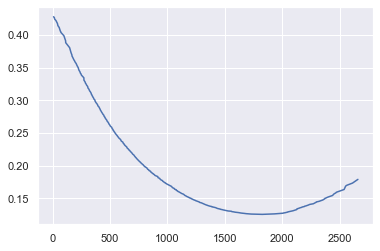

In [43]:
plt.plot(np.sort(y["time"]), ibs_ev[np.argsort(y["time"])])

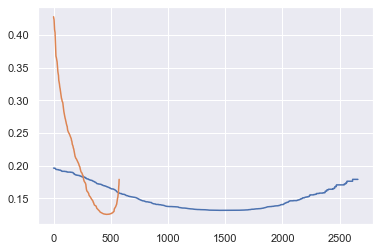

In [44]:
n_w = np.cumsum(np.bincount(y["time"].astype(int), weights=ibs_ev)[::-1])[::-1]
o_w = np.bincount(y["time"].astype(int), weights=ibs_ev)

n_j = np.cumsum(np.bincount(y["time"].astype(int))[::-1])[::-1]
o_j = np.bincount(y["time"].astype(int))

# plt.plot(n_w)
# plt.plot(n_j)
plt.plot(n_w/n_j)
plt.plot(o_w[o_w>0]/o_j[o_w>0])

In [45]:
def ind_for_nodes(X_attr, best_split_, is_categ):
    rule_id = best_split_["pos_nan"].index(0)
    query = best_split_["values"][rule_id]
    if is_categ:
        values = np.isin(X_attr, eval(query[query.find("["):]))
    else:
        values = eval("X_attr" + query)
    return np.where(values, rule_id, 1 - rule_id)

def fit_predict_KM(X_):
    y_ = get_y(time=X_[-1], cens=X_[-2])
#     print(y_["time"])
    kmf = KaplanMeierZeroAfter()
    kmf.fit(y_["time"], y_["cens"])
    sf = kmf.survival_function_at_times(bins_HO)
    sf = np.repeat(sf[np.newaxis, :], y_.shape[0], axis=0)
    print(f"IBS:{ibs_WW(y_, y_, sf, bins_HO):.5f}, AUPRC:{auprc(y_, y_, sf, bins_HO):.5f}, {X_.shape[1]}")

def get_ibs(X_, best_split_, f, is_categ):
    fit_predict_KM(X_)
    inds = ind_for_nodes(X_[f], best_split_, is_categ)
    fit_predict_KM(X_[:, np.where(inds == 0)[0]])
    fit_predict_KM(X_[:, np.where(inds == 1)[0]])

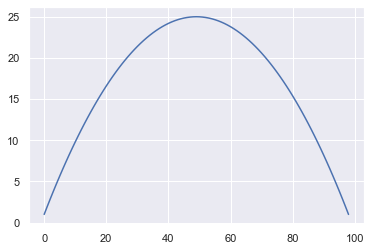

In [46]:
n1 = np.arange(1, 100)
plt.plot((n1*(100-n1))/100)

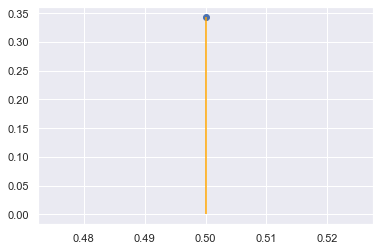

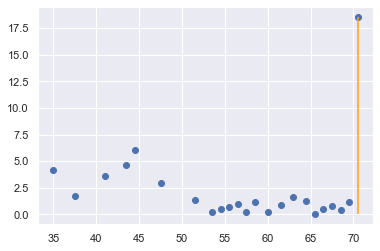

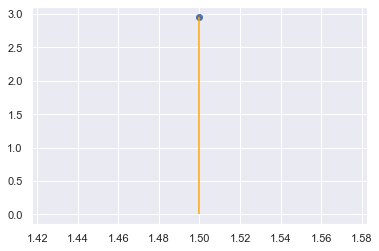

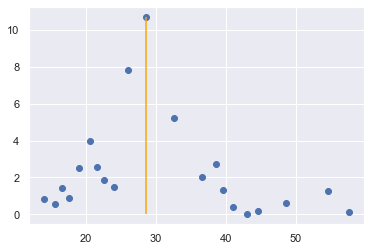

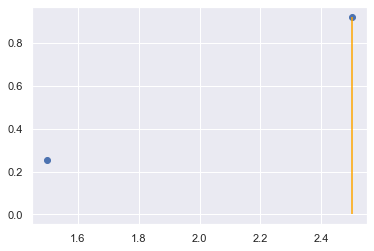

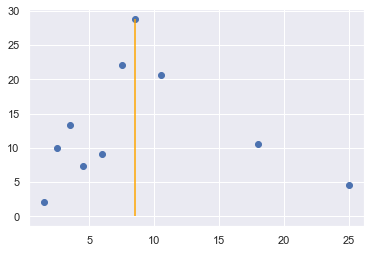

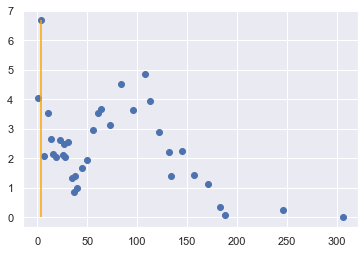

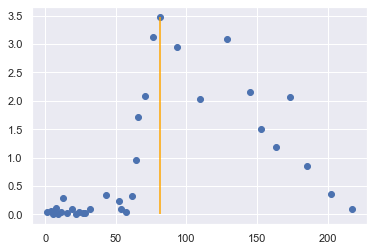

posnodal BEST FEATURE
IBS:0.13567, AUPRC:0.59426, 51
IBS:0.09688, AUPRC:0.70173, 40
IBS:0.08487, AUPRC:0.57813, 11


IndexError: boolean index did not match indexed array along dimension 0; dimension is 50 but corresponding boolean dimension is 51

In [51]:
X_ = df.loc[:50, features + [cnt.CENS_NAME, cnt.TIME_NAME]].to_numpy().T
for i_w, w in enumerate([np.ones(X_.shape[1]), ibs_full, weights_hist]):
    attr_by = {}
    for i_f, f in enumerate(features):
        d = tree.info.copy()
        d["arr"] = np.vstack((X_[i_f], X_[-2:]))
        d["type_attr"] = ("woe" if tree.woe else "categ") if f in tree.categ else "cont"
        d["weights"] = w
        a = hist_best_attr_split(**d)
        #print(f, w[:5], a)
        #get_ibs(X_, a, i_f, d["type_attr"] == "categ")
        attr_by[f] = a

    attr = max(attr_by, key=lambda x: attr_by[x]["stat_val"])
    print(attr, "BEST FEATURE")
    get_ibs(X_, attr_by[attr], features.index(attr), attr in tree.categ)